In [49]:
#Imports
from xgboost import XGBClassifier
import sys
sys.path.append('../scripts')
from evaluation_utils import evaluate_with_optimal_threshold
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [50]:

# Cargar todos los archivos CSV de la variante TCP BBR
csv_files = glob.glob("../data_processed/bbr/*.log.csv")
df = pd.concat([pd.read_csv(f, sep=',') for f in csv_files], ignore_index=True)
df.columns = df.columns.str.strip()
print(df.columns.tolist())   

print(f"Cantidad de registros: {df.shape[0]}")
df.head()

# Etiquetar eventos de congestión.
df['congestion_event'] = (df['cwnd'].diff().shift(-1) < -10).astype(int)
df.dropna(inplace=True)


['wscale', 'rto', 'rtt', 'mss', 'pmtu', 'rcvmss', 'advmss', 'cwnd', 'ssthresh', 'bytes_sent', 'bytes_retrans', 'bytes_acked', 'segs_out', 'segs_in', 'data_segs_out', 'lastrcv', 'delivered', 'rcv_space', 'rcv_ssthresh', 'timestamp', 'throughput', 'packets_sent', 'packets_acked', 'packets_lost', 'loss_rate']
Cantidad de registros: 179950


In [51]:
# Seleccionar features y target

features = ['cwnd', 'rtt', 'bytes_retrans', 'bytes_acked', 'throughput', 'packets_lost']
X = df[features]
y = df['congestion_event']


In [52]:
# Dividir entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
#Escalar los datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
#Entrenar modelo

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False
)

xgb_model.fit(X_train_scaled, y_train)



c:\Users\ian\Desktop\fing\tesis\Machine-Learning-CC\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:32:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None



 Threshold óptimo (max F1-score): 0.06

 Reporte de clasificación (threshold ajustado):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     35827
           1       0.14      0.34      0.20       163

    accuracy                           0.99     35990
   macro avg       0.57      0.66      0.59     35990
weighted avg       0.99      0.99      0.99     35990



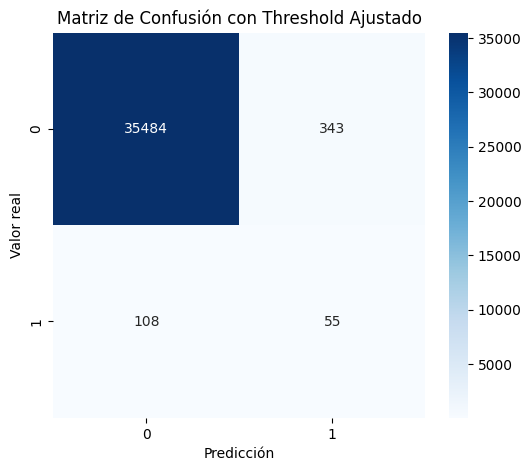

In [55]:
#Evaluar modelo
y_pred_xgb, best_threshold_xgb = evaluate_with_optimal_threshold(xgb_model, X_test_scaled, y_test)

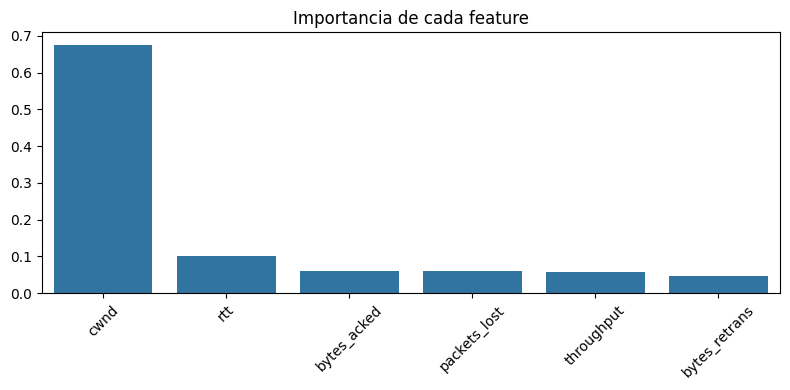

In [56]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
sns.barplot(x=np.array(features)[indices], y=importances[indices])
plt.xticks(rotation=45)
plt.title("Importancia de cada feature")
plt.tight_layout()
plt.show()